## Download data

In [1]:
!gdown --id 1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
!unzip -q "./datasets/FER-2013.zip"

/home/server1-ailab/miniconda3/envs/tuong_tf/lib/python3.8/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP
From (redirected): https://drive.google.com/uc?id=1bFx6uiQV-GUGwL3PwYRIYdmRCF9hS2bP&confirm=t&uuid=b9f36070-b9c7-4b05-922d-c121df10635d
To: /home/server1-ailab/Desktop/Tuong/Tensorflow_Tutorial/Machine_Learning/MLP/FER-2013.zip
100%|██████████████████████████████████████| 63.3M/63.3M [00:10<00:00, 5.90MB/s]


## Prepare data

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

2023-05-16 14:31:25.045733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:31:25.848643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataloader

In [6]:
batch_size = 256
img_height = 48
img_width = 48
train_dir = "./datasets/FER_2013/train" 
test_dir = "./datasets/FER_2013/test"   

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


2023-05-16 14:31:30.665758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 622 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


### Visualize

In [15]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

2023-05-06 15:03:31.210779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22968]
	 [[{{node Placeholder/_4}}]]
2023-05-06 15:03:31.211073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22968]
	 [[{{node Placeholder/_4}}]]


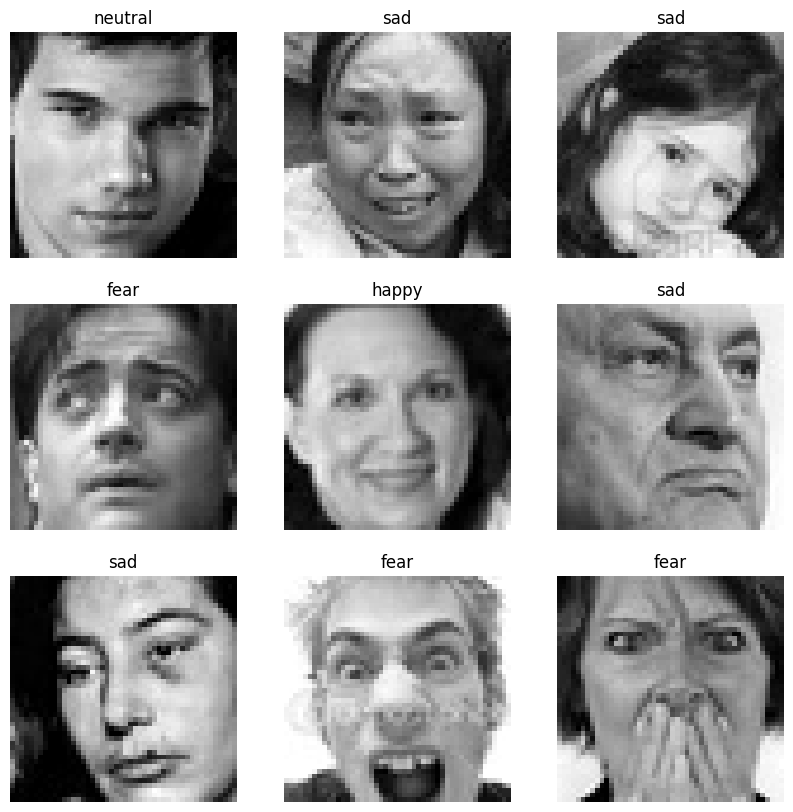

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i].numpy()).astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalize

In [17]:
normalized_train_ds = train_ds.map(lambda x, y: (tf.subtract(tf.divide(x, 127.5),1), y))
normalized_val_ds = val_ds.map(lambda x, y: (tf.subtract(tf.divide(x, 127.5),1), y))

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(buffer_size=512).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalized_train_ds = normalized_train_ds.cache().shuffle(buffer_size=512).prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training

### Softmax - Không Normalize

In [19]:
num_class = 7

# Create model
FER_SR_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=num_class)
])

FER_SR_model.summary()

# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)
# metric = tf.keras.metrics.SparseCategoricalAccuracy()
FER_SR_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# Training
FER_SR_history = FER_SR_model.fit(train_ds, validation_data=val_ds, epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 16135     
                                                                 
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-06 15:03:32.727453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [22968]
	 [[{{node Placeholder/_0}}]]
2023-05-06 15:03:32.727796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [22968]
	 [[{{node Placeholder/_4}}]]


90/90 [==============================] - ETA: 0s - loss: 85867.7109 - accuracy: 0.1798

2023-05-06 15:03:34.217330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5741]
	 [[{{node Placeholder/_0}}]]
2023-05-06 15:03:34.217927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5741]
	 [[{{node Placeholder/_4}}]]


90/90 [==============================] - 2s 10ms/step - loss: 85867.7109 - accuracy: 0.1798 - val_loss: 75063.8047 - val_accuracy: 0.1150
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 80472.0938 - accuracy: 0.1925 - val_loss: 70243.1719 - val_accuracy: 0.1852
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 72378.3281 - accuracy: 0.1970 - val_loss: 53418.4883 - val_accuracy: 0.2592
Epoch 4/100
90/90 [==============================] - 1s 8ms/step - loss: 66981.9688 - accuracy: 0.2075 - val_loss: 48016.6094 - val_accuracy: 0.2484
Epoch 5/100
90/90 [==============================] - 1s 8ms/step - loss: 65444.6250 - accuracy: 0.2110 - val_loss: 48728.3789 - val_accuracy: 0.2590
Epoch 6/100
90/90 [==============================] - 1s 8ms/step - loss: 62373.9727 - accuracy: 0.2178 - val_loss: 62112.9688 - val_accuracy: 0.2137
Epoch 7/100
90/90 [==============================] - 1s 8ms/step - loss: 59774.6641 - accuracy: 0.2184 - val_loss: 61

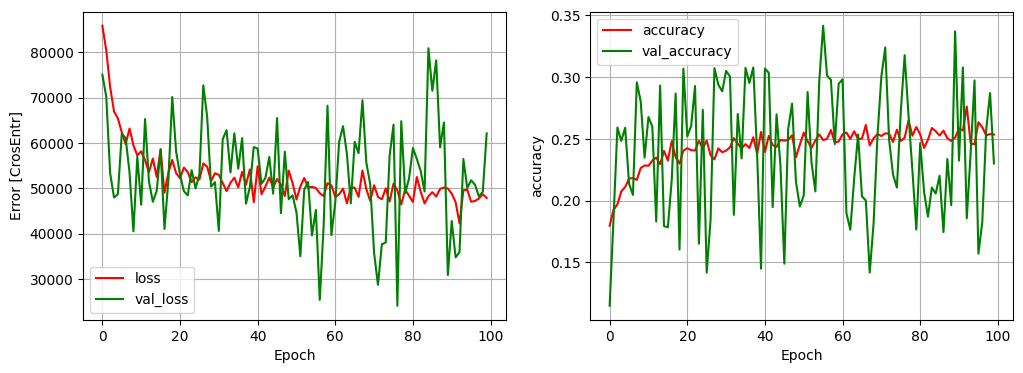

In [20]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(FER_SR_history.history['loss'], label='loss', color='red')
plt.plot(FER_SR_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(FER_SR_history.history['accuracy'], label='accuracy', color='red')
plt.plot(FER_SR_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)


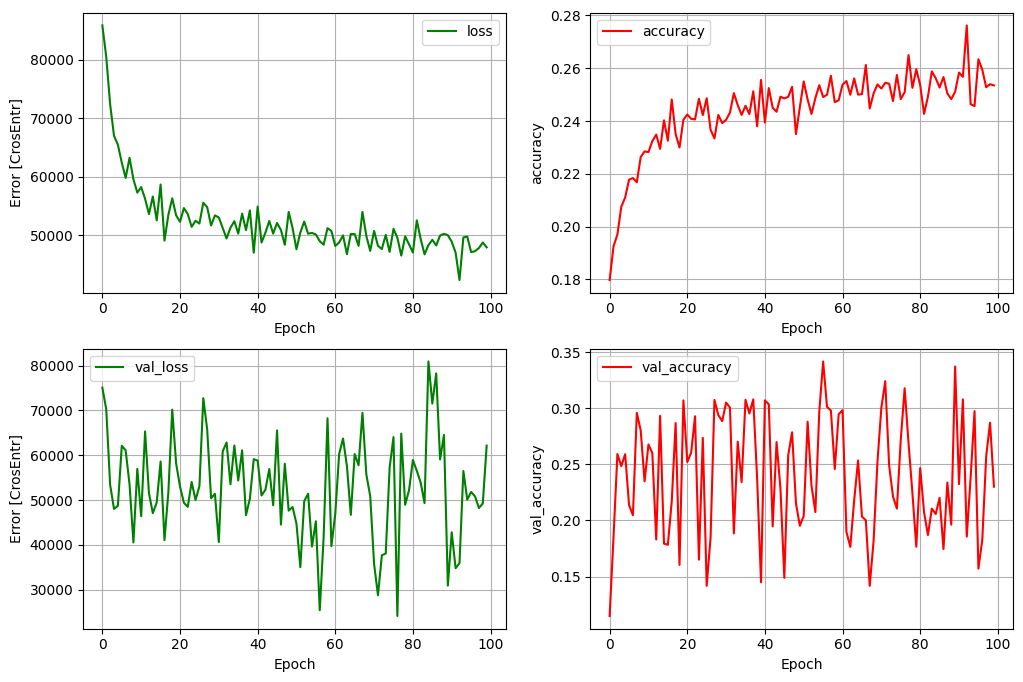

In [21]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(FER_SR_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(FER_SR_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(FER_SR_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(FER_SR_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [22]:
hist = pd.DataFrame(FER_SR_history.history)
hist['epoch'] = FER_SR_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,47069.535156,0.263410,51802.531250,0.157115,95
96,47237.000000,0.259448,50821.402344,0.182721,96
97,47764.140625,0.252786,48222.437500,0.257098,97
98,48712.218750,0.253962,49242.097656,0.287058,98
99,47891.902344,0.253483,62140.269531,0.230099,99


In [23]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.27621036767959595
Max val acc:  0.3415781259536743
Min train loss:  42301.46484375
Min val loss:  24149.05859375


### Softmax - Normalize

In [26]:
num_class = 7

# Create model
FER_SRN_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=num_class)
])

FER_SRN_model.summary()

# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)
# metric = tf.keras.metrics.SparseCategoricalAccuracy()
FER_SRN_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# Training
FER_SRN_history = FER_SRN_model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=100)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 16135     
                                                                 
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
90/90 [==============================] - 1s 9ms/step - loss: 1.8848 - accuracy: 0.2370 - val_loss: 1.8261 - val_accuracy: 0.2679
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 1.7925 - accuracy: 0.2863 - val_loss: 1.7836 - val_accuracy: 0.2881
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 1.7558 - accuracy: 0.3078 - val_loss: 1.7567 - val_accuracy: 0.3026
Epoch 4/100
90/90 [===

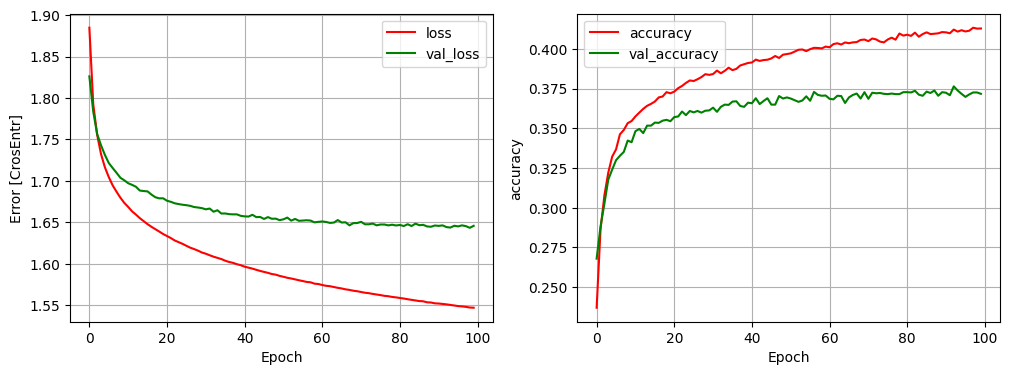

In [27]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(FER_SRN_history.history['loss'], label='loss', color='red')
plt.plot(FER_SRN_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(FER_SRN_history.history['accuracy'], label='accuracy', color='red')
plt.plot(FER_SRN_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)


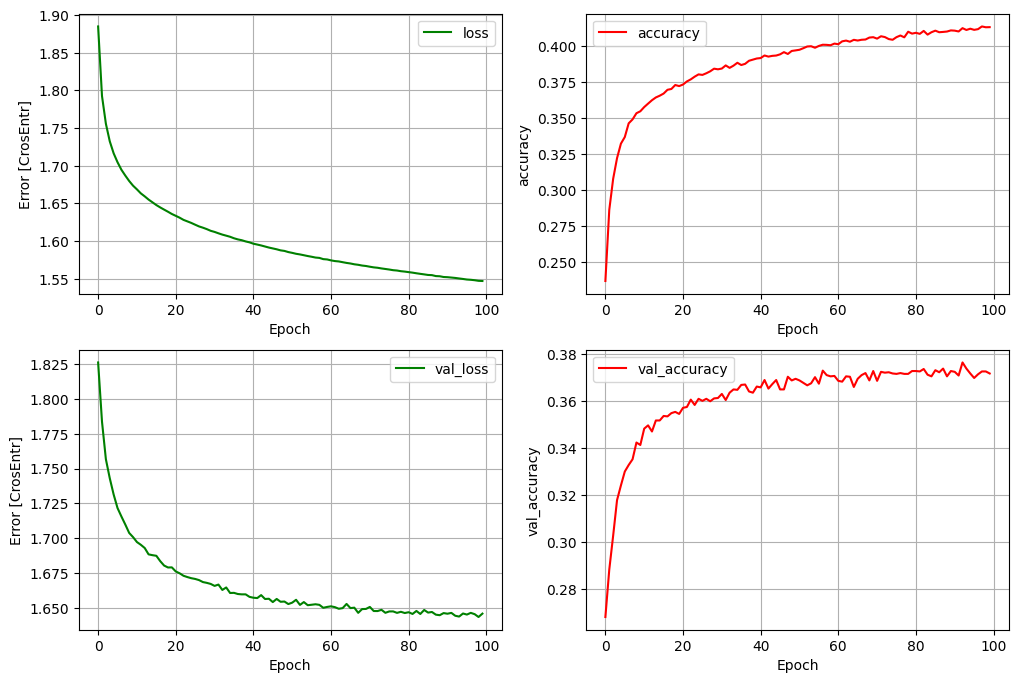

In [28]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(FER_SRN_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(FER_SRN_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(FER_SRN_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(FER_SRN_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [29]:
hist = pd.DataFrame(FER_SRN_history.history)
hist['epoch'] = FER_SRN_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.548985,0.411007,1.645155,0.369796,95
96,1.548628,0.411486,1.646377,0.371364,96
97,1.548069,0.413358,1.645445,0.372583,97
98,1.547262,0.412792,1.643413,0.372583,98
99,1.547031,0.412879,1.645833,0.371712,99


In [30]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.4133577048778534
Max val acc:  0.3764152526855469
Min train loss:  1.5470309257507324
Min val loss:  1.6434129476547241


### MLP - tanh

In [31]:
# build model
num_class = 7

MLP_tanh_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=1024, activation='tanh'),
    tf.keras.layers.Dense(units=512, activation='tanh'),
    tf.keras.layers.Dense(units=256, activation='tanh'),
    tf.keras.layers.Dense(units=num_class)
])
##################################################################

MLP_tanh_model.summary()
# compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)
MLP_tanh_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# training
MLP_tanh_history = MLP_tanh_model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=100)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2360320   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3,018,247
Trainable params: 3,018,247
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
90/90 [=========================

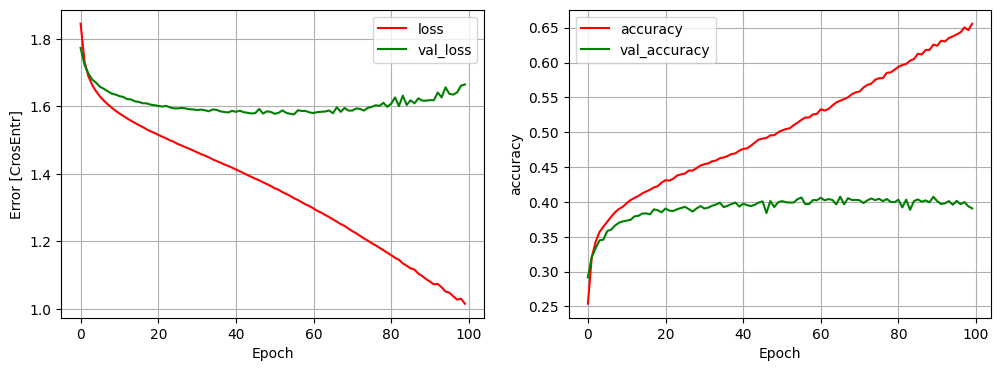

In [32]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='red')
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

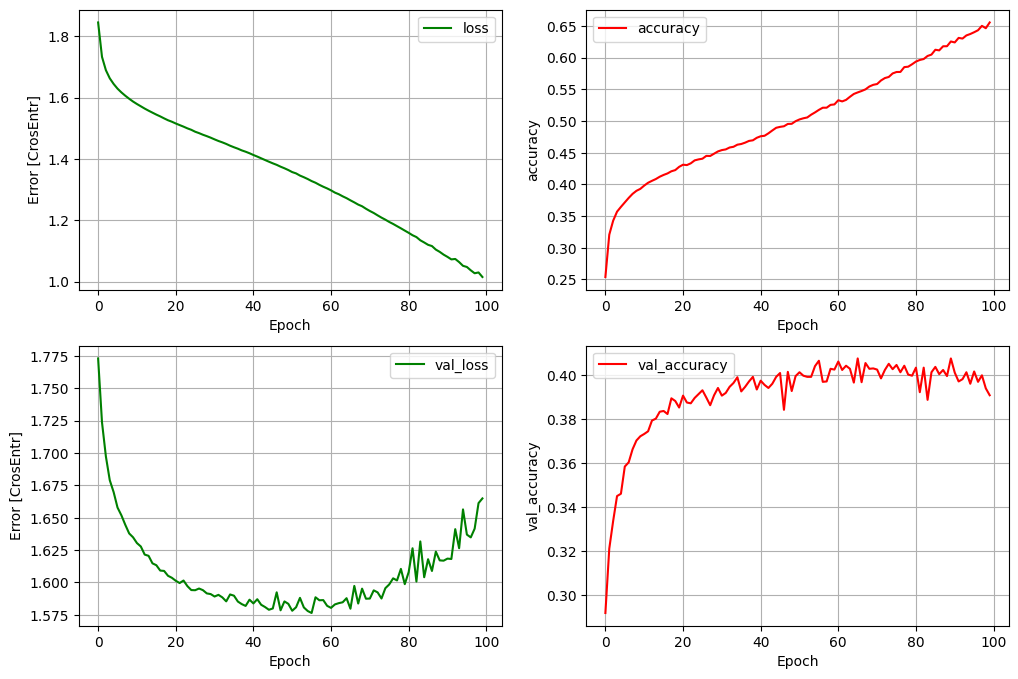

In [33]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)


In [34]:
hist = pd.DataFrame(MLP_tanh_history.history)
hist['epoch'] = MLP_tanh_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.048009,0.640239,1.636991,0.401498,95
96,1.037105,0.643373,1.634836,0.396795,96
97,1.027483,0.650253,1.641587,0.399756,97
98,1.030172,0.646552,1.661328,0.393834,98
99,1.015342,0.655651,1.664955,0.390698,99


In [35]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.655651330947876
Max val acc:  0.4074203073978424
Min train loss:  1.015342354774475
Min val loss:  1.5764108896255493


### MLP - relu

In [36]:
# build model
num_class = 7

MLP_tanh_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(units=1024, activation="tanh"),
    tf.keras.layers.Dense(units=512, activation="tanh"),
    tf.keras.layers.Dense(units=256, activation="tanh"),
    tf.keras.layers.Dense(units=num_class)
])
MLP_tanh_model.summary()

# compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.006)

MLP_tanh_model.compile(optimizer=opt,loss=loss, metrics=['accuracy'])

# training
MLP_tanh_history = MLP_tanh_model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=100)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 2304)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              2360320   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 3,018,247
Trainable params: 3,018,247
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
90/90 [=========================

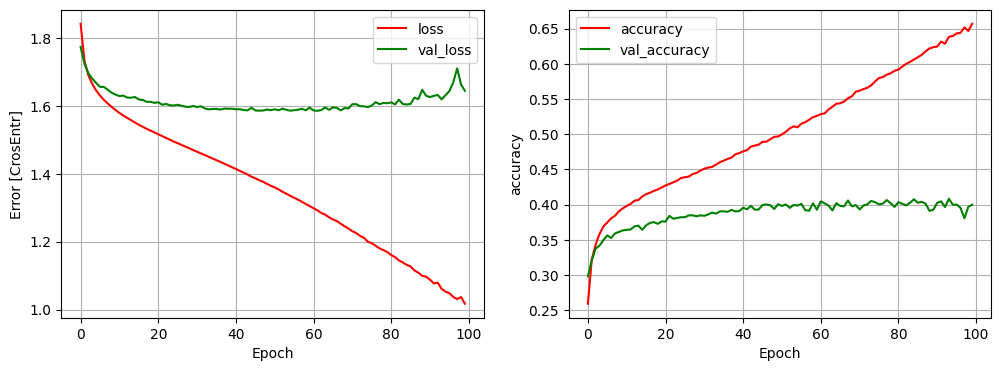

In [37]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='red')
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

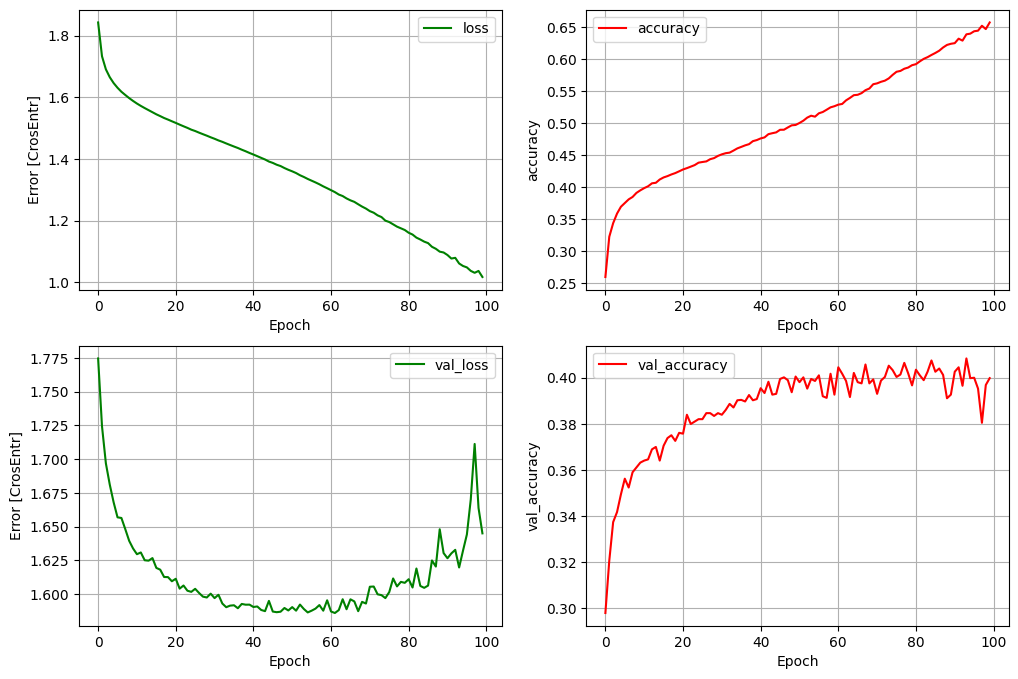

In [38]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(MLP_tanh_history.history['loss'], label='loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(MLP_tanh_history.history['accuracy'], label='accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(MLP_tanh_history.history['val_loss'], label='val_loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Error [CrosEntr]')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(MLP_tanh_history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend()
plt.grid(True)

In [39]:
hist = pd.DataFrame(MLP_tanh_history.history)
hist['epoch'] = MLP_tanh_history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.048239,0.643069,1.644236,0.399930,95
96,1.036952,0.643983,1.670159,0.395227,96
97,1.030662,0.651646,1.711224,0.380422,97
98,1.036764,0.646465,1.663838,0.396795,98
99,1.017071,0.656827,1.645035,0.399756,99


In [40]:
print("Max train acc: ", max(hist['accuracy']))
print("Max val acc: ", max(hist['val_accuracy']))

print("Min train loss: ", min(hist['loss']))
print("Min val loss: ", min(hist['val_loss']))

Max train acc:  0.656826913356781
Max val acc:  0.4082912504673004
Min train loss:  1.0170707702636719
Min val loss:  1.5860841274261475
